In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive')

#root_dir = '/content/gdrive/MyDrive/Data'

root_dir = '../../../Data'

Mounted at /content/gdrive


In [2]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from pandas.core.frame import DataFrame
from time import sleep
import math

Extracting labels

Getting participants section in the merged file

In [3]:
experience = 8
data_loading_dir = os.path.join(root_dir, "18 participants/AX3/DownsampledDataset" + str(experience))
participants = 1
sections = [0]
count = 0

for participant in range(1, participants + 1):
  file_name = os.path.join(data_loading_dir, "Dataset_participant" + str(participant) + ".pkl")
  new_dataset = pd.read_pickle(file_name)
  count = count + new_dataset.shape[0]
  sections.append(count)

data_loading_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))
save_file = os.path.join(data_loading_dir, "Sections.pkl")

sections_df = DataFrame({'Sections': sections})
sections_df.to_pickle(save_file)
#print(sections_df)

Extracting labelled and unlabelled dataset

In [6]:
participants = 1
experience = 8

psg_dir = os.path.join(root_dir, "18 participants/PSG")
features_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))

# PSG Files
PSG_Consensus_Sleep_profile = "SDRI001_PSG_Consensus Sleep profile_0"
PSG_Heart_Rate = "SDRI001_PSG_Heart Rate_0"
PSG_HRV_HF = "SDRI001_PSG_HRV HF_0"
PSG_HRV_LF = "SDRI001_PSG_HRV LF_0"
PSG_Position = "SDRI001_PSG_Position_0"
PSG_RR_Interval = "SDRI001_PSG_RR-Interval_0"
PSG_SpO2 = "SDRI001_PSG_SpO2_0"

def get_PSG_dataset(PSF_DIR, PSG_File, participant):
  file_name = os.path.join(PSF_DIR, PSG_File + str(participant).zfill(2) + "V4_N1.txt")
  dataset = pd.read_csv(file_name, sep=" ")
  return dataset

def reformatPSGDatetime(date, time):
  #File 9 Anamoly
  if not isinstance(date, str):
    after_midnight = 0
    if int(time[:2]) < 22:
      after_midnight = 1
    date = str(26+after_midnight) + ".02.2020"

  date = date.split('.')
  time = time.split(',')[0]
  datetime = date[2] + '-' + date[1] + '-' + date[0] + ' ' + time
  return datetime

def extractSleepProfileLabels(dataset, starting_rows=5):
  columns = np.array(dataset.columns)
  columns[0] = 'Date'
  columns[1] = 'Time'
  columns[2] = 'Sleep State'
  dataset.columns = columns
  dataset = dataset.iloc[starting_rows:]
  dataset['Label'] = dataset.apply(lambda x: reformatPSGDatetime(x['Date'], x['Time']), axis=1)
  dataset = dataset[['Label', 'Sleep State']]
  return dataset

def extractNonSleepProfileLabels(dataset, starting_rows=5):
  columns = np.array(dataset.columns)
  columns[0] = 'Date'
  columns[1] = 'Time'
  columns[2] = 'Value'
  columns[3] = 'Sleep State'
  #File 9 Anamoly
  if ',' in dataset.iloc[starting_rows][0]:
    columns[0] = 'Time'
    columns[1] = 'Value'
    columns[2] = 'Sleep State'
    columns[3] = 'Date'
    dataset.columns = columns
    print(dataset.iloc[starting_rows])
    print(dataset.iloc[starting_rows]['Date'])

  dataset.columns = columns
  dataset = dataset.iloc[starting_rows:]
  dataset['Label'] = dataset.apply(lambda x: reformatPSGDatetime(x['Date'], x['Time']), axis=1)
  dataset = dataset[['Label', 'Value', 'Sleep State']]
  return dataset

def get_Features_dataset(features_dir, file="Features.pkl"):
  file_name = os.path.join(features_dir, file)
  dataset = pd.read_pickle(file_name)
  return dataset

def getSection(features_dir):
  file_name = os.path.join(features_dir, "Sections.pkl")
  dataset = pd.read_pickle(file_name)
  dataset = np.array(dataset)
  return dataset.reshape(dataset.shape[0])

def get_Feature_Dataset(sections, features_dataset, participant):
  from_idx = sections[participant-1]
  to_idx = sections[participant]
  return features_dataset.iloc[from_idx:to_idx]

def extract_unlabelled_dataset(feature_dataset, psg_dataset):
  feature_dataset = pd.merge(feature_dataset, psg_dataset, how='left', on="Label")
  return feature_dataset[feature_dataset['Sleep State'].isnull()]

def SaveDataset(dataset, file_name):
  save_file = os.path.join(features_dir, file_name)
  dataset.to_pickle(save_file)

features_dataset = get_Features_dataset(features_dir)
raw_dataset = get_Features_dataset(features_dir, "Raw.pkl")
sections = getSection(features_dir)

Extracting labels of Heart rate and Positions dataset


In [8]:
#for i in range(1, 2):
  #psg_dataset = get_PSG_dataset(psg_dir, PSG_Heart_Rate, i)
  #psg_dataset = psg_dataset.reset_index()
  #psg_dataset = extractNonSleepProfileLabels(psg_dataset)

  #psg_dataset = get_PSG_dataset(psg_dir, PSG_Position, i)
  #psg_dataset = extractNonSleepProfileLabels(psg_dataset, 6)
  #print(psg_dataset.shape)
  #print(psg_dataset.head(7))

psg_dataset = get_PSG_dataset(psg_dir, PSG_Position, 1)
psg_dataset = psg_dataset.reset_index()
psg_dataset = extractNonSleepProfileLabels(psg_dataset, 6)
feature_dataset = get_Feature_Dataset(sections, features_dataset, 1)

labelled_dataset = pd.merge(feature_dataset, psg_dataset, on="Label")
unlabelled_dataset = extract_unlabelled_dataset(feature_dataset, psg_dataset)

for participant in range(2, participants + 1):
  psg_dataset = get_PSG_dataset(psg_dir, PSG_Position, participant)
  psg_dataset = psg_dataset.reset_index()
  print(participant)
  print(psg_dataset.shape)

  psg_dataset = extractNonSleepProfileLabels(psg_dataset, 6)
  feature_dataset = get_Feature_Dataset(sections, features_dataset, participant)

  new_labelled_dataset = pd.merge(feature_dataset, psg_dataset, on="Label")
  new_unlabelled_dataset = extract_unlabelled_dataset(feature_dataset, psg_dataset)

  labelled_dataset = labelled_dataset.append(new_labelled_dataset, ignore_index=True)
  unlabelled_dataset = unlabelled_dataset.append(new_unlabelled_dataset, ignore_index=True)

SaveDataset(labelled_dataset, "LabelledPOS")
SaveDataset(unlabelled_dataset, "UnlabelledPOS")

print(feature_dataset.shape)
print(labelled_dataset.shape)
print(unlabelled_dataset.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24620, 71)
(1200, 73)
(23420, 73)


Extracting labels of Sleep profile dataset

In [ ]:
psg_dataset = get_PSG_dataset(psg_dir, PSG_Consensus_Sleep_profile, 1)
psg_dataset = extractSleepProfileLabels(psg_dataset)
print(psg_dataset.shape)
feature_dataset = get_Feature_Dataset(sections, features_dataset, 1)

labelled_dataset = pd.merge(feature_dataset, psg_dataset, on="Label")
unlabelled_dataset = extract_unlabelled_dataset(feature_dataset, psg_dataset)

for participant in range(2, participants + 1):
  psg_dataset = get_PSG_dataset(psg_dir, PSG_Consensus_Sleep_profile, participant)
  psg_dataset = extractSleepProfileLabels(psg_dataset)
  feature_dataset = get_Feature_Dataset(sections, features_dataset, participant)

  new_labelled_dataset = pd.merge(feature_dataset, psg_dataset, on="Label")
  new_unlabelled_dataset = extract_unlabelled_dataset(feature_dataset, psg_dataset)

  labelled_dataset = labelled_dataset.append(new_labelled_dataset, ignore_index=True)
  unlabelled_dataset = unlabelled_dataset.append(new_unlabelled_dataset, ignore_index=True)

train_to_test_ratio = 0.9
n = labelled_dataset.shape[0]
split_point = n * train_to_test_ratio

SaveDataset(labelled_dataset, "Labelled")
SaveDataset(unlabelled_dataset, "Unlabelled")

print(psg_dataset.shape)
print(feature_dataset.shape)
print(labelled_dataset.shape)
print(unlabelled_dataset.shape)

(1201, 2)
(1201, 2)
(24620, 71)
(1201, 72)
(23419, 72)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


PseudoLabeling sleep stage

In [4]:
experience = 8

isRaw = False
extend = ""
if isRaw:
  extend = "Raw"

def convertMultiLabelToSingleLabel(result):
  res = 1
  if result < 4:
    res = 0
  return res

features_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))
file_name = os.path.join(features_dir, extend+"Labelled")

def encode_sleep_stage(val):
  arr = {'N1':0, 'N2':1, 'N3':2, 'REM':3, 'Wake':4, 'Artefact':np.NaN, 'A':np.NaN}
  return arr[val]

def encode_sleep_state(val):
  arr = {'N1':0, 'N2':1, 'N3':2, 'REM':3, 'Wake':4, 'Artefact':np.NaN, 'A':np.NaN}
  return arr[val]

dataset = pd.read_pickle(file_name)
dataset['Sleep State'] = dataset['Sleep State'].apply(lambda x: encode_sleep_stage(x))
dataset['Sleep State'] = pd.Series(np.array(dataset['Sleep State'])).interpolate()
dataset['Sleep State'] = np.array(dataset['Sleep State'].replace(to_replace = np.nan, value=4), dtype=np.int64)

file_name = os.path.join(features_dir, extend+"Unlabelled")
unlabelled_dataset = pd.read_pickle(file_name)
unlabelled_dataset = unlabelled_dataset.drop(['Label','Sleep State'], axis=1)

print(unlabelled_dataset.shape)
print(dataset.shape)

(23419, 70)
(1201, 72)


PseudoLabeling sleep/wake classification

In [21]:
experience = 8

isRaw = False
extend = ""
if isRaw:
  extend = "Raw"

def convertMultiLabelToSingleLabel(result):
  res = 1
  if result < 4:
    res = 0
  return res

features_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))
file_name = os.path.join(features_dir, extend+"Labelled")

def encode_sleep_stage(val):
  arr = {'N1':0, 'N2':1, 'N3':2, 'REM':3, 'Wake':4, 'Artefact':np.NaN, 'A':np.NaN}
  return arr[val]

def encode_sleep_state(val):
  arr = {'N1':0, 'N2':0, 'N3':0, 'REM':0, 'Wake':1, 'Artefact':np.NaN, 'A':np.NaN}
  return arr[val]

dataset = pd.read_pickle(file_name)
dataset['Sleep State'] = dataset['Sleep State'].apply(lambda x: encode_sleep_state(x))
dataset['Sleep State'] = pd.Series(np.array(dataset['Sleep State'])).interpolate()
dataset['Sleep State'] = np.array(dataset['Sleep State'].replace(to_replace = np.nan, value=4), dtype=np.int64)

file_name = os.path.join(features_dir, extend+"Unlabelled")
unlabelled_dataset = pd.read_pickle(file_name)
unlabelled_dataset = unlabelled_dataset.drop(['Label','Sleep State'], axis=1)

PseudoLabeling Sleep position

In [35]:
experience = 8

isRaw = False
extend = ""
if isRaw:
  extend = "Raw"

def convertMultiLabelToSingleLabel(result):
  res = 1
  if result < 4:
    res = 0
  return res

features_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))
file_name = os.path.join(features_dir, extend+"LabelledPOS")

def encode_sleep_stage(val):
  arr = {'N1':0, 'N2':1, 'N3':2, 'REM':3, 'Wake':4, 'Artefact':np.NaN, 'A':np.NaN}
  return arr[val]

def encode_sleep_pos(val):
  arr = {'Supine;':0, 'Upright;':1, 'Right;':2, 'Prone;':3, 'Left;':4, 'Artefact;':np.NaN, 'A;':np.NaN}
  return arr[val]

dataset = pd.read_pickle(file_name)
print(dataset['Value'].unique())
dataset['Value'] = dataset['Value'].apply(lambda x: encode_sleep_pos(x))
#print(dataset['Value'].unique())
dataset['Value'] = pd.Series(np.array(dataset['Value'])).interpolate()
dataset['Value'] = dataset['Value'].apply(lambda x: int(x))
print(dataset['Value'].unique())
#dataset = dataset.drop(['Sleep State'], axis=1)

#dataset['Sleep State'] = np.array(dataset['Sleep State'].replace(to_replace = np.nan, value=4), dtype=np.int64)
file_name = os.path.join(features_dir, extend+"Unlabelled")
unlabelled_dataset = pd.read_pickle(file_name)
unlabelled_dataset = unlabelled_dataset.drop(['Label', 'Sleep State'], axis=1)

['Supine;' 'Upright;' 'A;' 'Right;' 'Prone;' 'Left;']
[0 1 2 3 4]


PseudoLabeling Heartrate classification

In [45]:
#dataset['Sleep State'] = dataset['Sleep State'].apply(lambda x: encode_sleep_state(x))
experience = 8

isRaw = False
extend = ""
if isRaw:
  extend = "Raw"

def convertMultiLabelToSingleLabel(result):
  res = 1
  if result < 4:
    res = 0
  return res

features_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))
file_name = os.path.join(features_dir, extend+"LabelledHR")

def encode_sleep_stage(val):
  arr = {'N1':0, 'N2':1, 'N3':2, 'REM':3, 'Wake':4, 'Artefact':np.NaN, 'A':np.NaN}
  return arr[val]

def encode_sleep_hr(val):
  if val == 'A;':
    return np.NaN
  n = len(val)
  val = int(val[:n-1])
  if (val < 60):
    return 0
  if (val < 100 and val >= 60):
    return 1
  return 2

dataset = pd.read_pickle(file_name)
#print(dataset['Value'].unique())
dataset['Value'] = dataset['Value'].apply(lambda x: encode_sleep_hr(x))
dataset['Value'] = pd.Series(np.array(dataset['Value'])).interpolate()
dataset['Value'] = dataset['Value'].apply(lambda x: int(x))
print(dataset['Value'].unique())

file_name = os.path.join(features_dir, extend+"Unlabelled")
unlabelled_dataset = pd.read_pickle(file_name)
unlabelled_dataset = unlabelled_dataset.drop(['Label','Sleep State'], axis=1)

#print(unlabelled_dataset.head(1))

[0 1 2]


In [9]:
def train_test_split(dataset, test_train_ratio, number_bags=10):
  dataset_bag_size = int(dataset.shape[0]/number_bags)
  separation_point = int(dataset_bag_size * test_train_ratio)
  dataset_split = dataset[:dataset_bag_size]
  dataset_train = dataset_split[:separation_point]
  dataset_test = dataset_split[separation_point:]

  for i in range(1, number_bags):
    dataset_split = dataset[i*dataset_bag_size:dataset_bag_size * (i+1)]
    new_dataset_train = dataset_split[:separation_point]
    new_dataset_test = dataset_split[separation_point:]
    dataset_train = dataset_train.append(new_dataset_train, ignore_index = True)
    dataset_test = dataset_test.append(new_dataset_test, ignore_index = True)

  return dataset_train, dataset_test

def train_test_split_rand(dataset, test_train_ratio):
  n = dataset.shape[0]
  split_point = int((1-test_train_ratio) * n)
  randIdx_test = random.sample(range(0, dataset.shape[0]), split_point)
  randIdx_train = np.setdiff1d(range(0, dataset.shape[0]), randIdx_test)

  dataset_train = dataset.iloc[randIdx_train]
  dataset_test = dataset.iloc[randIdx_test]
  return dataset_train, dataset_test


print(dataset.shape)
train_test_ratio = 0.9

dataset_size = dataset.shape[0]
split_point = int(train_test_ratio * dataset_size)

labels = np.array(dataset['Sleep State'])
dataset_train = dataset.drop(['Label','Sleep State'], axis=1)

#labels = np.array(dataset['Value'])
#dataset_train = dataset.drop(['Label','Sleep State', 'Value'], axis=1)

#x_train = dataset_train[:split_point]
#x_test = dataset_train[split_point:]
#y_train = labels[:split_point]
#y_test = labels[split_point:]

#x_train, x_test = train_test_split(dataset, train_test_ratio, number_bags=1500)
x_train, x_test = train_test_split_rand(dataset, train_test_ratio)

y_train = np.array(x_train['Sleep State'])
y_test = np.array(x_test['Sleep State'])

x_train = np.array(x_train.drop(['Label','Sleep State'], axis=1))
x_test = np.array(x_test.drop(['Label','Sleep State'], axis=1))

print(x_train.shape)
print(x_test.shape)

#y_train = np.array(x_train['Value'])
#y_test = np.array(x_test['Value'])

#x_train = x_train.drop(['Label', 'Sleep State', 'Value'], axis=1)
#x_test = x_test.drop(['Label', 'Sleep State', 'Value'], axis=1)

(1201, 72)
(1081, 70)
(120, 70)


Random Forest Model

[[ 5  3  0  1  2]
 [ 3 24  3  2  3]
 [ 0  1 15  0  0]
 [ 0  0  0 23  0]
 [ 0  1  0  0 34]]
Precision, Recall and F1 Score for N1 are 0.62, 0.45, 0.52
Precision, Recall and F1 Score for N2 are 0.83, 0.69, 0.75
Precision, Recall and F1 Score for N3 are 0.83, 0.94, 0.88
Precision, Recall and F1 Score for REM are 0.88, 1.0, 0.94
Precision, Recall and F1 Score for Wake are 0.87, 0.97, 0.92
(5, 5)
Accuracy is 0.84
Performance is 0.81


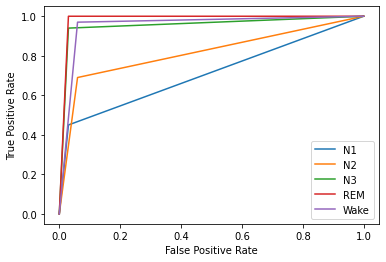

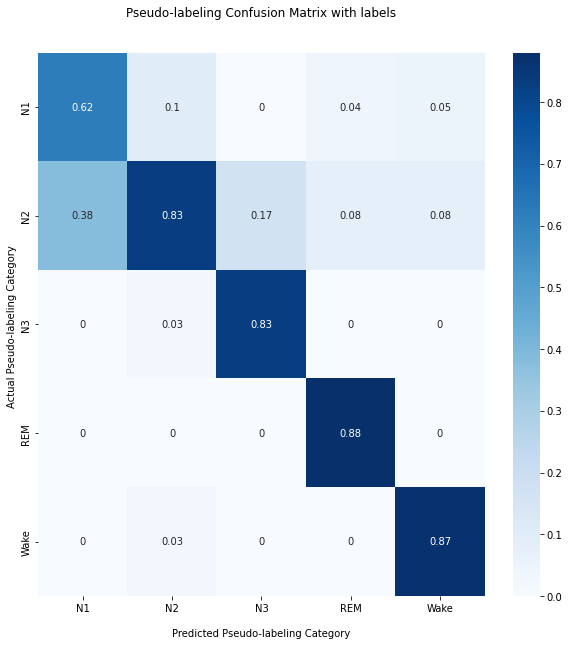

([0.62, 0.83, 0.83, 0.88, 0.87], 0.84)

In [10]:
from keras.callbacks import learning_rate_schedule
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(bootstrap=True,
                                  #max_features = 'sqrt',
                                  n_estimators=1500)

rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)

Labels = ['N1','N2', 'N3', 'REM', 'Wake']
#Labels = ['Sleep', 'Wake']
#Labels = ['Supine','Upright','Right','Prone','Left']
#Labels = ['Low','Normal', 'High']

printConfusionMatrix(y_test, y_pred, Labels)

Data labelling

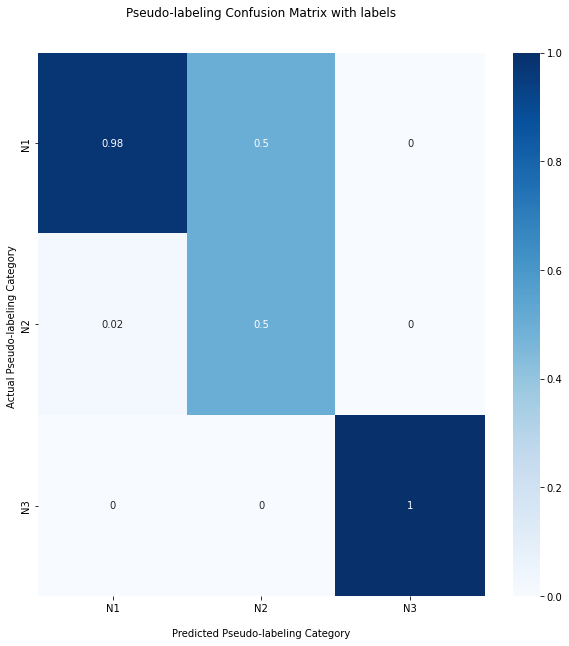

In [14]:
show_confusion_mat([[0.98, 0.5, 0],[0.02, 0.5, 0],[0,0,1]], Labels)

In [11]:
save_sleep_labels = os.path.join(features_dir, extend+"SleepStageLabels")
#save_sleep_labels = os.path.join(features_dir, extend+"SleepWakeLabels")
#save_sleep_labels = os.path.join(features_dir, extend+"SleepPosLabels")
#save_sleep_labels = os.path.join(features_dir, extend+"SleepHRLabels")

y_pred = rf_model.predict(np.array(unlabelled_dataset))

print(np.unique(y_pred, return_counts=True))
print(np.unique(y_pred, return_counts=True)[1]/y_pred.shape[0])
print(np.unique(y_train, return_counts=True))
print(np.unique(y_train, return_counts=True)[1]/y_train.shape[0])

np.save(save_sleep_labels, y_pred)

(array([0, 1, 2, 3, 4]), array([  523,   921,   221,   144, 21610]))
[0.02233229 0.03932704 0.00943678 0.00614885 0.92275503]
(array([0, 1, 2, 3, 4]), array([133, 246, 134, 154, 414]))
[0.12303423 0.22756707 0.1239593  0.14246068 0.38297872]


In [ ]:
print(np.unique(y_pred, return_counts=True))
print(np.unique(y_pred, return_counts=True)[1]/y_pred.shape[0])
print(np.unique(y_train, return_counts=True))
print(np.unique(y_train, return_counts=True)[1]/y_train.shape[0])
#y_train

(array([0, 1]), array([ 97053, 399118]))
[0.19560393 0.80439607]
(array([0, 1, 4]), array([12186,  5102,     1]))
[7.04841229e-01 2.95100931e-01 5.78402452e-05]


[link text]Gradient Boosting Trees

(1920, 49)
[[ 45  69   3  12  61]
 [ 28 544  23  12  67]
 [  4  37 221   1  13]
 [  6  22   0 126  29]
 [ 45  86   7  13 446]]
Precision, Recall and F1 Score for N1 are 0.35, 0.24, 0.28
Precision, Recall and F1 Score for N2 are 0.72, 0.81, 0.76
Precision, Recall and F1 Score for N3 are 0.87, 0.8, 0.83
Precision, Recall and F1 Score for REM are 0.77, 0.69, 0.73
Precision, Recall and F1 Score for Wake are 0.72, 0.75, 0.73
(5, 5)
Accuracy is 0.69
Performance is 0.67


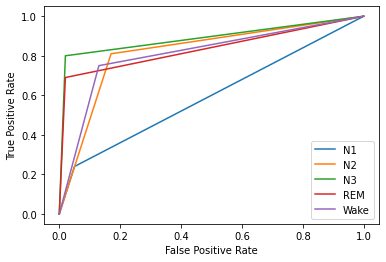

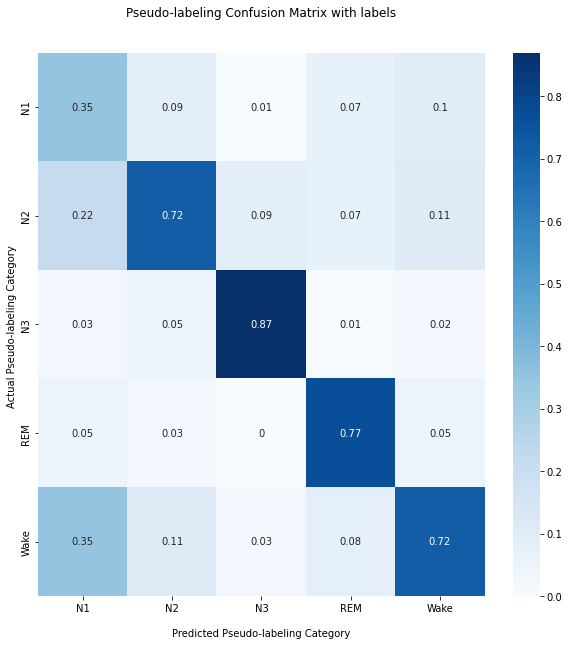

([0.35, 0.72, 0.87, 0.77, 0.72], 0.69)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

print(x_test.shape)

#test_labels_single = list(map(convertMultiLabelToSingleLabel, test_labels))
#print(test_labels.value_counts())

rf_model = GradientBoostingClassifier(n_estimators=400, learning_rate=0.6)
rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)

Labels = ['N1','N2', 'N3', 'REM', 'Wake']

printConfusionMatrix(y_test, y_pred, Labels, show=True)

#Labels = ['Sleep', 'Wake']
#y_pred_single = list(map(convertMultiLabelToSingleLabel, y_pred))

#printConfusionMatrix(test_labels_single, y_pred_single, Labels)

KNN

[[ 19  98  21   9  43]
 [ 82 376  68  35 113]
 [ 33 144  23  16  60]
 [ 18 100  15  15  35]
 [ 60 269  57  26 185]]
Precision, Recall and F1 Score for N1 are 0.09, 0.1, 0.09
Precision, Recall and F1 Score for N2 are 0.38, 0.56, 0.45
Precision, Recall and F1 Score for N3 are 0.12, 0.08, 0.1
Precision, Recall and F1 Score for REM are 0.15, 0.08, 0.1
Precision, Recall and F1 Score for Wake are 0.42, 0.31, 0.36
(5, 5)
Accuracy is 0.23
Performance is 0.23


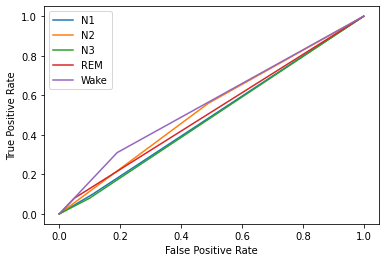

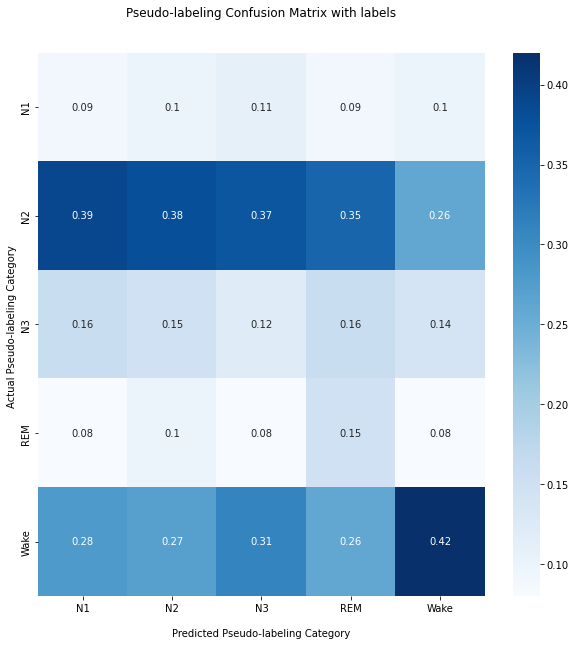

([0.09, 0.38, 0.12, 0.15, 0.42], 0.23)

In [ ]:
from keras.callbacks import learning_rate_schedule
from sklearn.neighbors import KNeighborsClassifier

rf_model = KNeighborsClassifier()

rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)

Labels = ['N1','N2', 'N3', 'REM', 'Wake']

printConfusionMatrix(y_test, y_pred, Labels)

LR Model

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars


[[  0 150   0   0  40]
 [  0 591   1   0  82]
 [  0 252   0   0  24]
 [  0 148   0   0  35]
 [  0 290   0   1 306]]
Precision, Recall and F1 Score for N1 are nan, 0.0, nan
Precision, Recall and F1 Score for N2 are 0.41, 0.88, 0.56
Precision, Recall and F1 Score for N3 are 0.0, 0.0, nan
Precision, Recall and F1 Score for REM are 0.0, 0.0, nan
Precision, Recall and F1 Score for Wake are 0.63, 0.51, 0.56
(5, 5)
Accuracy is nan
Performance is nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars


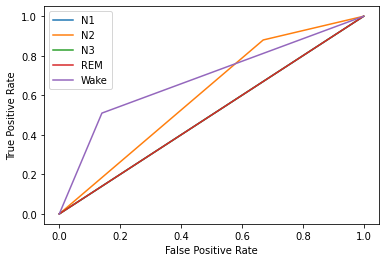

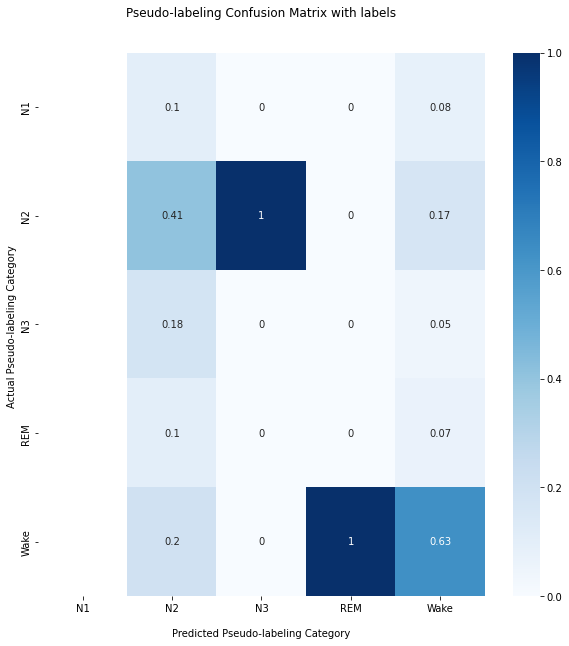

([nan, 0.41, 0.0, 0.0, 0.63], nan)

In [ ]:
from keras.callbacks import learning_rate_schedule
from sklearn.linear_model import LogisticRegression

rf_model = LogisticRegression(penalty='l2', solver='newton-cg')

rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)

Labels = ['N1','N2', 'N3', 'REM', 'Wake']

printConfusionMatrix(y_test, y_pred, Labels)

In [ ]:
from keras.callbacks import learning_rate_schedule
from sklearn.linear_model import LogisticRegression

rf_model = LogisticRegression(penalty='l2', solver='newton-cg')

rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)

Labels = ['N1','N2', 'N3', 'REM', 'Wake']

printConfusionMatrix(y_test, y_pred, Labels)

SVM

[[  0 190   0   0   0]
 [  0 674   0   0   0]
 [  0 276   0   0   0]
 [  0 183   0   0   0]
 [  0 597   0   0   0]]
Precision, Recall and F1 Score for N1 are nan, 0.0, nan
Precision, Recall and F1 Score for N2 are 0.35, 1.0, 0.52
Precision, Recall and F1 Score for N3 are nan, 0.0, nan
Precision, Recall and F1 Score for REM are nan, 0.0, nan
Precision, Recall and F1 Score for Wake are nan, 0.0, nan
(5, 5)
Accuracy is nan
Performance is nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars


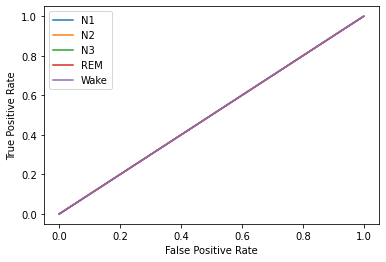

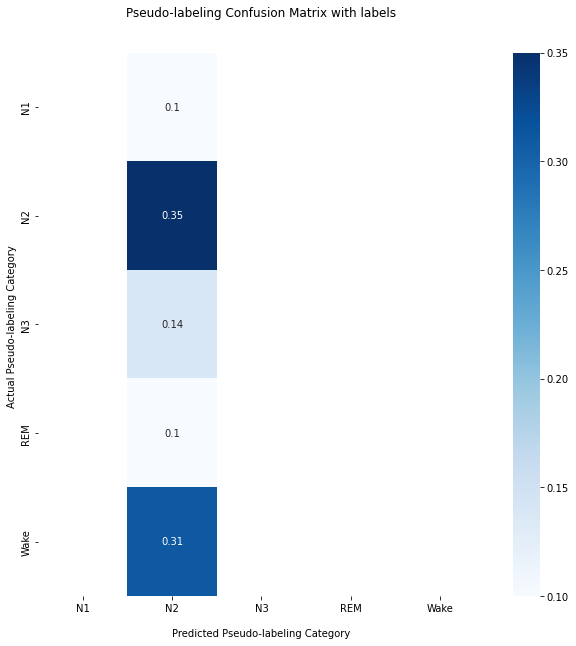

([nan, 0.35, nan, nan, nan], nan)

In [ ]:
from sklearn import svm

clf = svm.SVC(gamma=0.01,C=10)

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

Labels = ['N1','N2', 'N3', 'REM', 'Wake']

printConfusionMatrix(y_test, y_pred, Labels)

DT

[[ 57  52   7  16  58]
 [ 73 466  37  20  78]
 [  5  42 215   1  13]
 [ 12   9   6 137  19]
 [ 69  83  13  20 412]]
Precision, Recall and F1 Score for N1 are 0.26, 0.3, 0.28
Precision, Recall and F1 Score for N2 are 0.71, 0.69, 0.7
Precision, Recall and F1 Score for N3 are 0.77, 0.78, 0.77
Precision, Recall and F1 Score for REM are 0.71, 0.75, 0.73
Precision, Recall and F1 Score for Wake are 0.71, 0.69, 0.7
(5, 5)
Accuracy is 0.63
Performance is 0.64


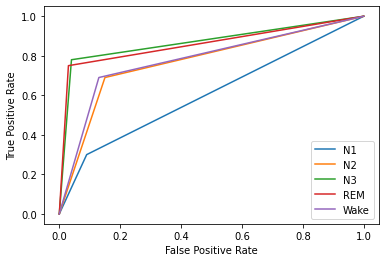

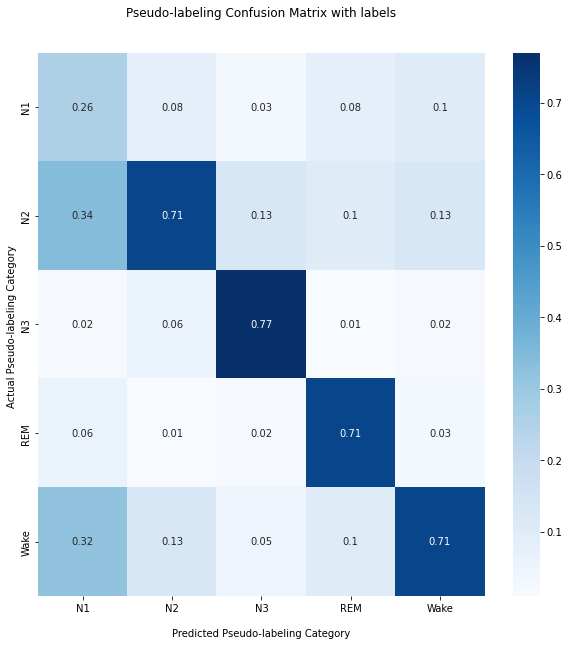

([0.26, 0.71, 0.77, 0.71, 0.71], 0.63)

In [ ]:
from keras.callbacks import learning_rate_schedule
from sklearn.tree import DecisionTreeClassifier

rf_model = DecisionTreeClassifier()

rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)

Labels = ['N1','N2', 'N3', 'REM', 'Wake']

printConfusionMatrix(y_test, y_pred, Labels)

CNN Module

In [ ]:
n = dataset.shape[0]
train_ratio = 0.9
separate_id = int(n * train_ratio)

labels = np.zeros((n,5))

for i in range(n):
  label = dataset.iloc[i]['Sleep State']
  labels[i][label] = 1

print(dataset['Sleep State'].value_counts())
dataset = dataset.drop(['Label', 'Sleep State'], axis=1)
dataset += 0.001
dataset = np.array(dataset)

dataset = dataset.reshape((dataset.shape[0], dataset.shape[1], 1, 1))

x_train = dataset[:separate_id]
y_train = labels[:separate_id]

x_test = dataset[separate_id:]
y_test = labels[separate_id:]

print(dataset.shape)
#print(dataset[0])
print(labels.shape)

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
#create model
model = Sequential()
#add model layers
model.add(Conv2D(24, kernel_size=(1,1), activation='relu', input_shape=(dataset.shape[1],1,1)))
#model.add(MaxPooling2D((1,1)))
model.add(Conv2D(16, kernel_size=(1,1), activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(5, activation='softmax'))

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
sgd = SGD(learning_rate=0.01)
rms = RMSprop(learning_rate=0.001)
adam = Adam(learning_rate=0.003, epsilon=0.01)
model.compile(optimizer=rms,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=1 ,validation_data=(x_test, y_test), epochs=50)

def plot_graph(x, y, z, x_label, y_label, legends, figsize=(7,7)):
  plt.plot(z, x, 'r--')
  plt.plot(z, y, 'b-')
  plt.legend(legends)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.figure(figsize=figsize)
  plt.show();

history = model.history

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Get training and test loss histories
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

plot_graph(training_loss, test_loss, epoch_count, 'Epoch', 'Loss', ['Training Loss', 'Test Loss'])
plot_graph(accuracy, val_accuracy, epoch_count, 'Epoch', 'Accuracy', ['Accuracy', 'Test Accuracy'])

test_labels = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(x_test), axis=1)
Labels = ['N1','N2', 'N3', 'REM', 'Wake']

printConfusionMatrix(test_labels, y_pred, Labels, show=True)


NameError: ignored

SVM Module train/test dataset

Result methods

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns


def printConfusionMatrix(test_labels, y_pred, Labels, show=True):
  cf_matrix = confusion_matrix(test_labels, y_pred)
  #cf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

  print(cf_matrix)

  precisions = []

  total_vals = 0  
  tps = 0
  for i in range(cf_matrix.shape[0]):
    sum_vals = cf_matrix[i].sum()
    total_vals += sum_vals
    tps += cf_matrix[i][i]
    precision = round(cf_matrix[i][i]/sum_vals, 2)
    precisions.append(precision)
    if show:
      print("Precision for " + Labels[i] + " is " + str(precision))

  accuracy = round(tps/total_vals, 2)
  if show:
    print("Accuracy is " + str(accuracy))
    #plot_confusion_matrix(conf_mat=cf_matrix, show_normed=True, figsize=(7,7))

    fig, siz = plt.subplots(figsize=(7,7))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', ax=siz)

    ax.set_title('Pseudo Labeling Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Labeling Category')
    ax.set_ylabel('Actual Labeling Category ');

    ## Ticket labels - List must be in alphabetical order

    ax.xaxis.set_ticklabels(Labels)
    ax.yaxis.set_ticklabels(Labels)

    ## Display the visualization of the Confusion Matrix.
    plt.show()

  return precisions, accuracy

Running SVM module

Gamma: 0.01
[[  2 153   4   2  48]
 [  9 468  18   7 153]
 [  4 205   5   9  56]
 [  0 146   5   1  45]
 [  4 404  19   4 149]]
[[1038  302]
 [ 431  149]]
Precision for Sleep is 0.77
Precision for Wake is 0.26
Accuracy is 0.62


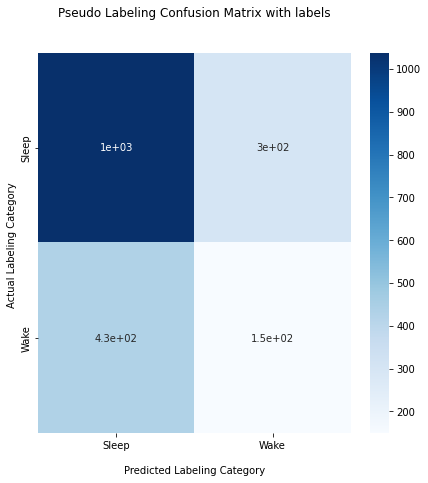

Gamma: 0.03
[[  2 171   2   2  32]
 [  5 526   7   6 111]
 [  4 227   5   3  40]
 [  0 157   0   2  38]
 [  4 454  12   2 108]]
[[1119  221]
 [ 472  108]]
Precision for Sleep is 0.84
Precision for Wake is 0.19
Accuracy is 0.64


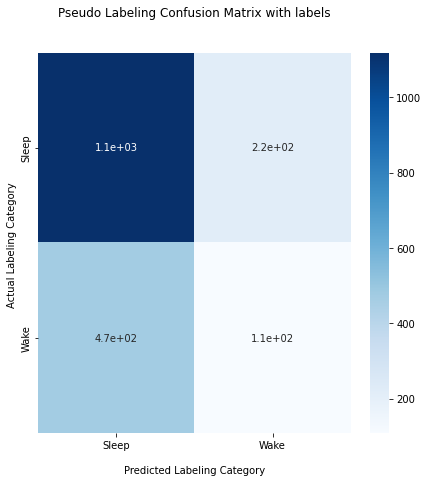

Gamma: 0.05
[[  3 177   1   1  27]
 [  3 565   8   2  77]
 [  5 239   3   1  31]
 [  0 164   0   1  32]
 [  3 486  10   1  80]]
[[1173  167]
 [ 500   80]]
Precision for Sleep is 0.88
Precision for Wake is 0.14
Accuracy is 0.65


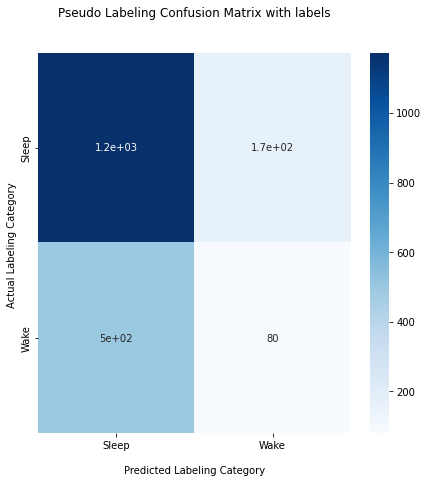

Gamma: 0.07
[[  3 180   1   1  24]
 [  4 577   6   1  67]
 [  4 244   2   1  28]
 [  0 168   1   1  27]
 [  2 501   8   1  68]]
[[1194  146]
 [ 512   68]]
Precision for Sleep is 0.89
Precision for Wake is 0.12
Accuracy is 0.66


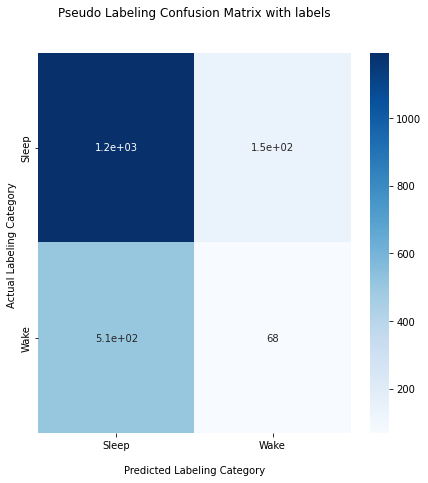

Gamma: 0.09
[[  3 183   1   1  21]
 [  5 584   7   3  56]
 [  3 249   1   1  25]
 [  0 172   2   1  22]
 [  2 506   7   1  64]]
[[1216  124]
 [ 516   64]]
Precision for Sleep is 0.91
Precision for Wake is 0.11
Accuracy is 0.67


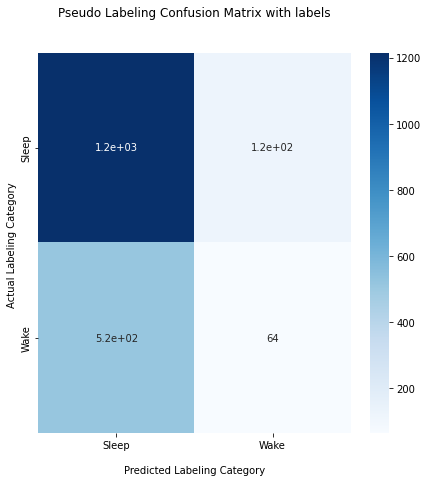

Gamma: 0.11
[[  3 186   1   0  19]
 [  3 586  11   4  51]
 [  1 251   1   2  24]
 [  0 173   2   0  22]
 [  2 513   7   1  57]]
[[1224  116]
 [ 523   57]]
Precision for Sleep is 0.91
Precision for Wake is 0.1
Accuracy is 0.67


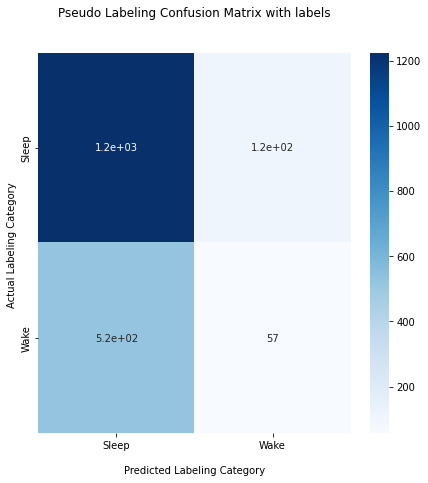

Gamma: 0.13
[[  2 186   1   0  20]
 [  4 593  10   4  44]
 [  1 254   1   2  21]
 [  0 176   2   0  19]
 [  2 519   5   1  53]]
[[1236  104]
 [ 527   53]]
Precision for Sleep is 0.92
Precision for Wake is 0.09
Accuracy is 0.67


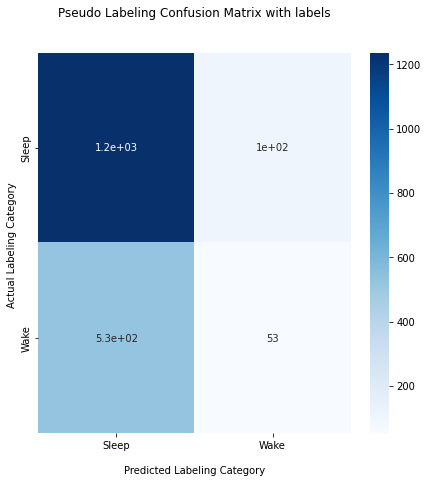

Gamma: 0.15
[[  1 186   2   0  20]
 [  3 599   9   3  41]
 [  1 254   1   2  21]
 [  0 176   2   0  19]
 [  2 525   4   1  48]]
[[1239  101]
 [ 532   48]]
Precision for Sleep is 0.92
Precision for Wake is 0.08
Accuracy is 0.67


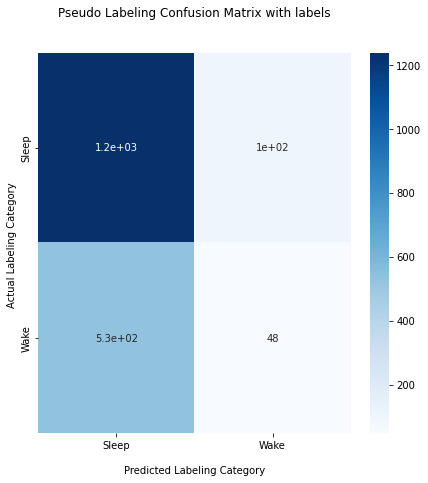

Gamma: 0.17
[[  1 192   1   0  15]
 [  3 607   8   1  36]
 [  1 255   1   2  20]
 [  0 178   2   1  16]
 [  2 527   4   0  47]]
[[1253   87]
 [ 533   47]]
Precision for Sleep is 0.94
Precision for Wake is 0.08
Accuracy is 0.68


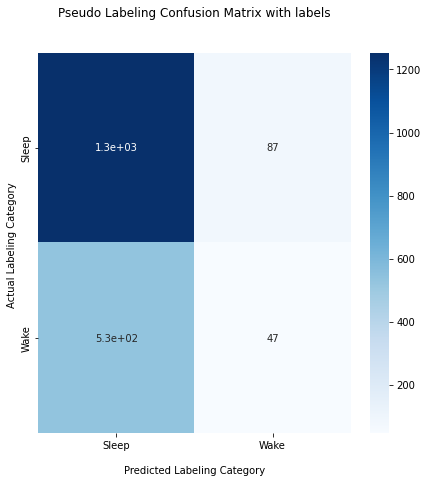

Gamma: 0.19
[[  1 193   1   0  14]
 [  3 610   8   1  33]
 [  1 257   0   2  19]
 [  0 178   2   1  16]
 [  2 533   3   0  42]]
[[1258   82]
 [ 538   42]]
Precision for Sleep is 0.94
Precision for Wake is 0.07
Accuracy is 0.68


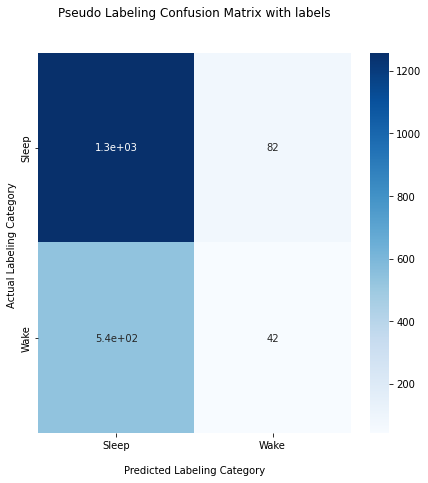

Gamma: 0.21
[[  1 192   1   0  15]
 [  2 612   7   0  34]
 [  1 258   0   2  18]
 [  0 181   2   1  13]
 [  2 535   3   0  40]]
[[1260   80]
 [ 540   40]]
Precision for Sleep is 0.94
Precision for Wake is 0.07
Accuracy is 0.68


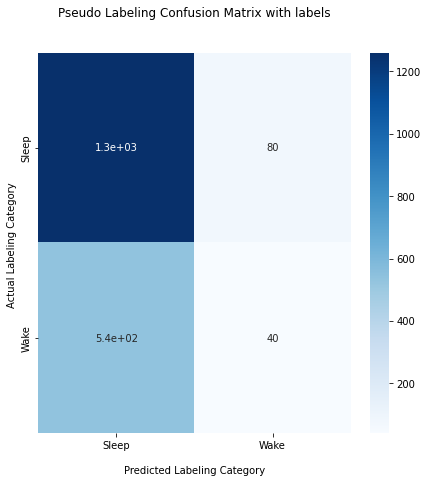

Gamma: 0.23
[[  1 193   1   0  14]
 [  2 613   7   0  33]
 [  1 259   0   2  17]
 [  0 182   2   1  12]
 [  2 537   3   0  38]]
[[1264   76]
 [ 542   38]]
Precision for Sleep is 0.94
Precision for Wake is 0.07
Accuracy is 0.68


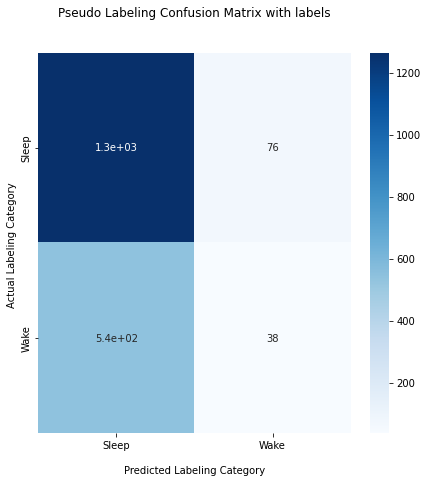

Gamma: 0.25
[[  1 194   1   0  13]
 [  1 616   6   0  32]
 [  1 262   0   2  14]
 [  0 183   2   1  11]
 [  1 539   3   0  37]]
[[1270   70]
 [ 543   37]]
Precision for Sleep is 0.95
Precision for Wake is 0.06
Accuracy is 0.68


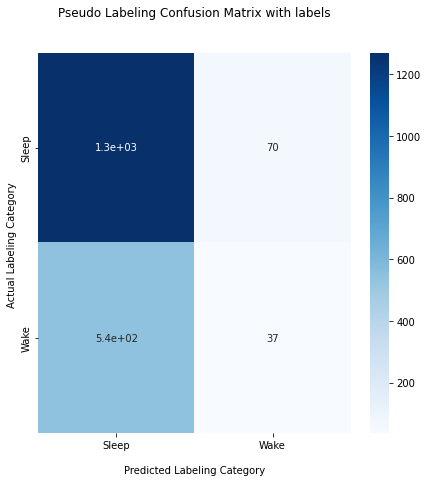

Gamma: 0.27
[[  1 195   1   0  12]
 [  1 616   6   0  32]
 [  1 263   0   2  13]
 [  1 183   2   1  10]
 [  1 541   3   0  35]]
[[1273   67]
 [ 545   35]]
Precision for Sleep is 0.95
Precision for Wake is 0.06
Accuracy is 0.68


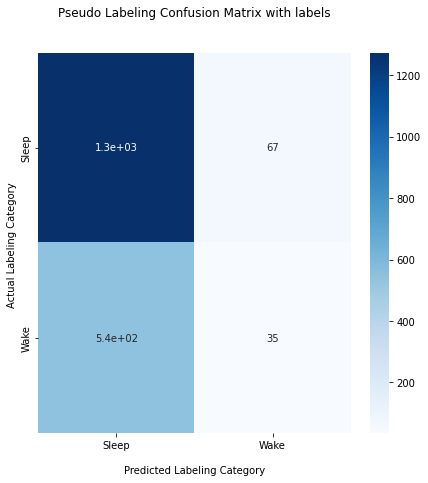

Gamma: 0.29
[[  1 195   1   0  12]
 [  1 616   6   0  32]
 [  1 263   0   2  13]
 [  1 185   2   1   8]
 [  1 541   3   0  35]]
[[1275   65]
 [ 545   35]]
Precision for Sleep is 0.95
Precision for Wake is 0.06
Accuracy is 0.68


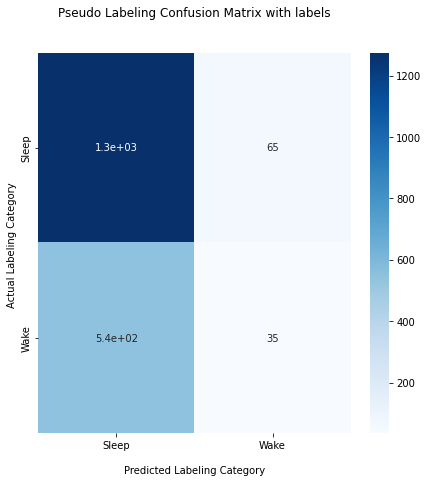

Gamma: 0.31
[[  1 195   1   0  12]
 [  1 618   6   0  30]
 [  1 262   0   2  14]
 [  1 185   2   1   8]
 [  1 544   1   0  34]]
[[1276   64]
 [ 546   34]]
Precision for Sleep is 0.95
Precision for Wake is 0.06
Accuracy is 0.68


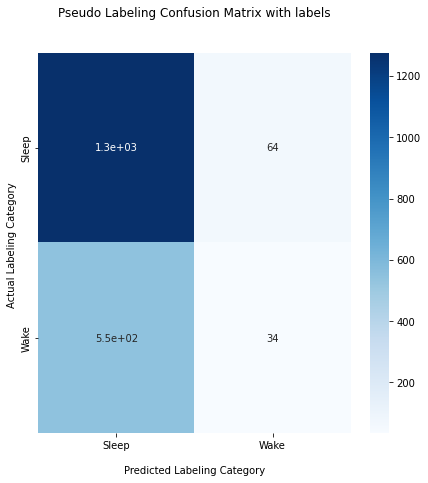

Gamma: 0.33
[[  0 196   1   0  12]
 [  1 622   5   0  27]
 [  0 263   0   2  14]
 [  1 185   2   1   8]
 [  1 546   1   0  32]]
[[1279   61]
 [ 548   32]]
Precision for Sleep is 0.95
Precision for Wake is 0.06
Accuracy is 0.68


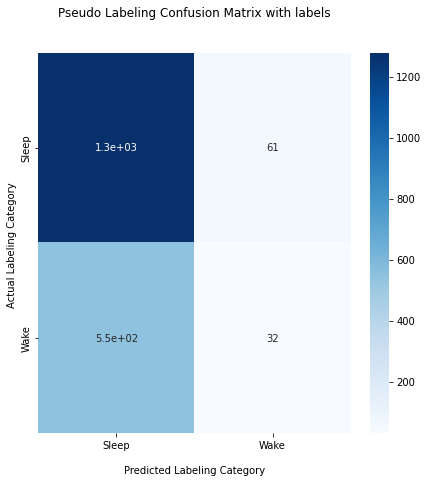

Gamma: 0.35
[[  0 196   1   0  12]
 [  1 620   5   1  28]
 [  0 263   0   2  14]
 [  1 186   2   1   7]
 [  1 547   1   0  31]]
[[1279   61]
 [ 549   31]]
Precision for Sleep is 0.95
Precision for Wake is 0.05
Accuracy is 0.68


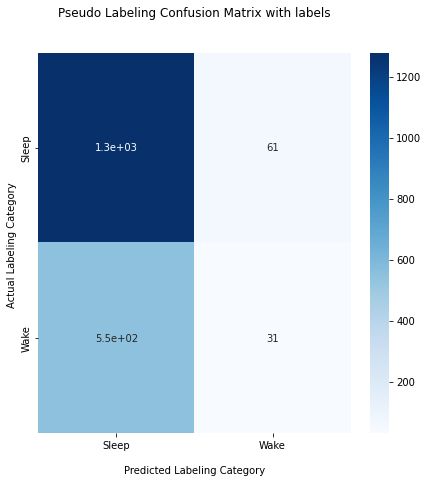

In [ ]:
from sklearn import svm
test_labels_single = list(map(convertMultiLabelToSingleLabel, test_labels))
#print(test_labels.value_counts())

clf = svm.SVC(gamma=0.1)
clf.fit(train_set, train_labels)

y_pred = clf.predict(test_set)

Labels = ['N1','N2', 'N3', 'REM', 'Wake']

printConfusionMatrix(test_labels, y_pred, Labels, False)

Labels = ['Sleep', 'Wake']
y_pred_single = list(map(convertMultiLabelToSingleLabel, y_pred))

printConfusionMatrix(test_labels_single, y_pred_single, Labels)  

Finding the optimal gamma value for SVM

In [ ]:
from sklearn import svm
test_labels_single = list(map(convertMultiLabelToSingleLabel, test_labels))
train_labels_single = list(map(convertMultiLabelToSingleLabel, train_labels))

gammas = []
precisions_individual_test = []
accuracies_individual_test = []

precisions_SW_test = []
accuracies_SW_test = []

precisions_individual_train = []
accuracies_individual_train = []

precisions_SW_train = []
accuracies_SW_train = []

for gamma in range(5, 1005, 5):
  gammas.append(gamma/10000)

  clf = svm.SVC(kernel='rbf', C=10, gamma=(gamma/10000))
  clf.fit(train_set, train_labels)

  print("Gamma: " + str(gamma/10000))

  y_pred = clf.predict(test_set)

  Labels = ['N1','N2', 'N3', 'REM', 'Wake']
  precision_individual_test, accuracy_individual_test = printConfusionMatrix(test_labels, y_pred, Labels, False)
  precisions_individual_test.append(precision_individual_test)
  accuracies_individual_test.append(accuracy_individual_test)

  Labels = ['Sleep', 'Wake']
  y_pred_single = list(map(convertMultiLabelToSingleLabel, y_pred))

  precision_SW_test, accuracy_SW_test = printConfusionMatrix(test_labels_single, y_pred_single, Labels, False)
  precisions_SW_test.append(precision_SW_test)
  accuracies_SW_test.append(accuracy_SW_test)

  y_pred = clf.predict(train_set)

  Labels = ['N1','N2', 'N3', 'REM', 'Wake']
  precision_individual_train, accuracy_individual_train = printConfusionMatrix(train_labels, y_pred, Labels, False)
  precisions_individual_train.append(precision_individual_train)
  accuracies_individual_train.append(accuracy_individual_train)

  Labels = ['Sleep', 'Wake']
  y_pred_single = list(map(convertMultiLabelToSingleLabel, y_pred))

  precision_SW_train, accuracy_SW_train = printConfusionMatrix(train_labels_single, y_pred_single, Labels, False)
  precisions_SW_train.append(precision_SW_train)
  accuracies_SW_train.append(accuracy_SW_train)


Gamma: 0.0005
[[  3 145   9   7  62]
 [ 29 406  35  29 128]
 [ 13 180  15   9  60]
 [  9 130  12   9  49]
 [ 36 304  31  27 183]]
[[1040  299]
 [ 398  183]]
[[ 679  862   46   19  308]
 [  46 5170   64   27  602]
 [  35 1230  861   28  309]
 [  35  858   45  706  270]
 [  62 1506   72   28 3421]]
[[10711  1489]
 [ 1668  3421]]
Gamma: 0.001
[[  7 136  15   8  60]
 [ 41 379  37  31 139]
 [ 15 179  12  17  54]
 [  8 125  15  10  51]
 [ 42 293  33  28 185]]
[[1035  304]
 [ 396  185]]
[[ 896  693   52   22  251]
 [  54 5264   69   26  496]
 [  31  986 1162   29  255]
 [  40  679   47  917  231]
 [  48 1190   73   23 3755]]
[[10967  1233]
 [ 1334  3755]]
Gamma: 0.0015
[[  4 132  18   8  64]
 [ 35 360  46  41 145]
 [ 19 167  15  15  61]
 [  9 120  14  14  52]
 [ 37 290  38  32 184]]
[[1017  322]
 [ 397  184]]
[[1038  579   46   18  233]
 [  46 5339   77   21  426]
 [  28  828 1350   28  229]
 [  30  586   41 1049  208]
 [  45  968   61   25 3990]]
[[11104  1096]
 [ 1099  3990]]
Gamma: 0.002
[

[[   0 2135    0    0    5]
 [   0 6526    0    0   10]
 [   0 2735    0    0    5]
 [   0 2118    0    0    5]
 [   0 5654    0    0   16]]


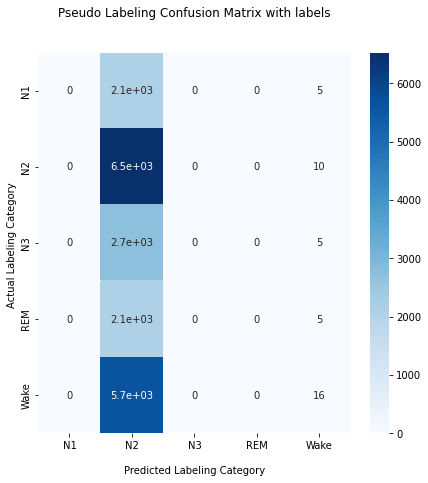

[1 1 1 ... 1 1 1]
[4 4 4 ... 4 4 4]


In [ ]:
y_pred = np.argmax(model.predict(dataset), axis=1)
y_labels = np.argmax(labels, axis=1)

Labels = ['N1','N2', 'N3', 'REM', 'Wake']

printConfusionMatrix(y_labels, y_pred, Labels)

#Labels = ['Sleep', 'Wake']
#y_pred = list(map(convertMultiLabelToSingleLabel, y_pred))
#test_labels = list(map(convertMultiLabelToSingleLabel, test_labels))

#printConfusionMatrix(y_labels, y_pred, Labels)

print(y_pred)
print(y_labels)

In [13]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
from sklearn import metrics

#printConfusionMatrix(y_test, y_pred, Labels, show=True)

def printConfusionMatrix(test_labels, y_pred, Labels, show=True):
  cf_matrix = confusion_matrix(test_labels, y_pred)
  #cf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
  
  print(cf_matrix)

  precisions = []
  recalls = []
  f1_scores = []
  FPRs = []
  n = len(test_labels)

  total_vals = 0
  tps = 0
  for i in range(cf_matrix.shape[0]):
    sum_vals = cf_matrix[i].sum()
    sum_cols = cf_matrix[:, i].sum()

    total_vals += sum_vals
    tps += cf_matrix[i][i]
    recall = round(cf_matrix[i][i]/sum_vals, 2)
    recalls.append(recall)
    precision = round(cf_matrix[i][i]/sum_cols, 2)
    precisions.append(precision)
    f1_score = round(2 * precision * recall / (recall + precision), 2)
    f1_scores.append(f1_score)
    
    # ROC
    TN = n - sum_vals - sum_cols + cf_matrix[i][i]
    FP = sum_cols - cf_matrix[i][i]
    FPR = round(FP / (FP + TN), 2)
    FPRs.append(FPR)
    if show:
      print("Precision, Recall and F1 Score for " + Labels[i] + " are " + str(precision) + ", " + str(recall) + ", " + str(f1_score))
      plt.plot([0,FPR, 1],[0,recall,1])

  accuracy = round(tps/total_vals, 2)
  performance = round((np.array(f1_scores).sum()+np.array(recalls).sum()+np.array(precisions).sum())/(3*len(Labels)), 2)

  cf_mat = np.zeros((cf_matrix.shape[0], cf_matrix.shape[0]))
  print(cf_mat.shape)
  for i in range(cf_matrix.shape[0]):
    for j in range(cf_matrix.shape[0]):
      cols_sum = cf_matrix[:,j].sum()
      cf_mat[i][j] = round(cf_matrix[i][j]/cols_sum, 2)

  if show:
    print("Accuracy is " + str(accuracy))
    print("Performance is " + str(performance))
    #plot_confusion_matrix(conf_mat=cf_matrix, show_normed=True, figsize=(7,7))

    #create ROC curve
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(Labels)
    plt.show()

    fig, siz = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(cf_mat, annot=True, cmap='Blues', ax=siz)


    ax.set_title('Pseudo-labeling Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Pseudo-labeling Category')
    ax.set_ylabel('Actual Pseudo-labeling Category ');

    ## Ticket labels - List must be in alphabetical order

    ax.xaxis.set_ticklabels(Labels)
    ax.yaxis.set_ticklabels(Labels)

    ## Display the visualization of the Confusion Matrix.
    plt.show()

  return precisions, accuracy

def show_confusion_mat(cf_mat, Labels):
  fig, siz = plt.subplots(figsize=(10,10))
  ax = sns.heatmap(cf_mat, annot=True, cmap='Blues', ax=siz)


  ax.set_title('Pseudo-labeling Confusion Matrix with labels\n\n');
  ax.set_xlabel('\nPredicted Pseudo-labeling Category')
  ax.set_ylabel('Actual Pseudo-labeling Category ');

  ## Ticket labels - List must be in alphabetical order

  ax.xaxis.set_ticklabels(Labels)
  ax.yaxis.set_ticklabels(Labels)

def get_n_rand_nums(start, end, totalNums):
  randIdx = random.sample(range(start, end), totalNums)
  randIdx.sort()
  return randIdx

# divides up the array to two arrays using the ids array
def separateArr(arr, ids):
  ids_id = 0
  part_1 = []
  part_2 = []

  print(arr.shape)

  for i in range(arr.shape[0]):
    row = arr[i]
    if ids_id < len(ids) and i == ids[ids_id]:
      part_2.append(row)
      ids_id += 1
    else:
      part_1.append(row)

  return np.array(part_1), np.array(part_2)

Dimension Reduction Model

In [ ]:
from sklearn.decomposition import PCA

dataset_reduced = dataset.drop(['Label', 'Sleep State'], axis=1)

pca = PCA()
x_pca = pca.fit_transform(dataset_reduced)
x_pca = pd.DataFrame(x_pca)
x_pca.head()

explained_variance = pca.explained_variance_ratio_
print(explained_variance.shape)
print(dataset.shape)

print(explained_variance)

dataset.head(3)

(49,)
(19209, 51)
[9.79980052e-01 1.89050846e-02 6.02020766e-04 3.44831293e-04
 1.00604615e-04 2.88791216e-05 1.62574470e-05 1.53248820e-05
 3.28364104e-06 3.20572872e-06 1.43986725e-07 1.15271959e-07
 9.37144264e-08 3.20697033e-08 2.55187924e-08 2.07266133e-08
 1.49595287e-08 1.35758773e-08 1.02240323e-08 7.55468665e-09
 4.90502661e-09 4.41456205e-09 2.16276019e-09 1.24324862e-09
 1.01884601e-09 6.64696687e-10 6.08819550e-10 5.77660586e-10
 3.98567346e-10 2.78367052e-10 2.42859982e-10 1.97313499e-10
 1.19688814e-10 1.14398019e-10 8.18639947e-11 6.30539995e-11
 4.22714953e-11 3.17624746e-11 2.02527214e-11 1.48098894e-12
 3.03325954e-14 2.77036542e-14 2.50850459e-15 2.50850459e-15
 2.50850459e-15 2.50850459e-15 2.50850459e-15 2.50850459e-15
 2.50850459e-15]


,Label,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,Sleep State
0,2020-02-12 22:15:00,0.0,0.0,0.0,88.395622,0.0,2.445408,1.514477,0.0,3753.799316,...,0.0,0.0,0.000000,2.281084,0.000000,104.074699,0.000000,0.0,0.000000,4
1,2020-02-12 22:15:30,0.0,0.0,0.0,86.787346,0.0,4.585591,0.000000,0.0,3863.186768,...,0.0,0.0,0.000000,0.000000,0.000000,163.851120,0.000000,0.0,0.000000,4
2,2020-02-12 22:16:00,0.0,0.0,0.0,85.784904,0.0,4.360070,0.000000,0.0,3972.406494,...,0.0,0.0,635.825745,179.180557,13.679484,756.231140,48.529282,0.0,32.980507,4


In [12]:
labels = np.array(dataset['Sleep State'])
new_dataset = np.array(dataset.iloc[[0]])

new_dataset = new_dataset.reshape((new_dataset.shape[0], 1))

n = dataset.shape[0]
train_ratio = 0.9

def get_n_rand_nums(start, end, totalNums):
  randIdx = random.sample(range(start, end), totalNums)
  randIdx.sort()
  return randIdx

randIdx = random.sample(range(0, n), int(n*(1-train_ratio)))
randIdx.sort()

# divides up the array to two arrays using the ids array
def separateArr(arr, ids):
  ids_id = 0
  part_1 = []
  part_2 = []

  print(arr.shape)

  for i in range(arr.shape[0]):
    row = arr[i]
    if ids_id < len(ids) and i == ids[ids_id]:
      part_2.append(row)
      ids_id += 1
    else:
      part_1.append(row)

  return np.array(part_1), np.array(part_2)

print(randIdx)

# spliting the original dataset to train/test splits
train_set, test_set = separateArr(new_dataset, randIdx)
train_labels, test_labels = separateArr(labels, randIdx)

print(train_set.shape)
print(test_set.shape)

print(train_labels.shape)
print(test_labels.shape)

ValueError: ignored